### K-Means Clustering
- To undergo K-means clustering, we must first convert the captions to word embeddings
- UMAP is used to reduce dimensionality to the data to allow for better clustering
- Clustering with a fixed cluster size can be achieved with scikit k-means
- Clustering with a non fixed cluster size can be achieved with HDBScan

In [12]:
#required imports
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans

import umap
import hdbscan

#### Preparing the data

In [13]:
#import data
blip_train = pd.read_csv("../../input/Landscape/Train/Labels/Blip_Label.csv", index_col=0)
blip_test = pd.read_csv("../../input/Landscape/Test/Labels/Blip_Label.csv", index_col=0)
blip_val = pd.read_csv("../../input/Landscape/Validation/Labels/Blip_Label.csv", index_col=0)

kosmos_train = pd.read_csv("../../input/Landscape/Train/Labels/Kosmos_Label.csv", index_col=0)
kosmos_test = pd.read_csv("../../input/Landscape/Test/Labels/Kosmos_Label.csv", index_col=0)
kosmos_val = pd.read_csv("../../input/Landscape/Validation/Labels/Kosmos_Label.csv", index_col=0)

In [14]:
#creating dataframe of all the captions
blip = pd.concat([blip_train, blip_test, blip_val])
kosmos = pd.concat([kosmos_train, kosmos_test, kosmos_val])

In [15]:
blip

,image_filename,image_caption
0,image_00001.jpg,a beach with sand dunes and blue sky
1,image_00002.jpg,a tropical island with white sand and palm trees
2,image_00003.jpg,four people sit on the beach with umbrellas an...
3,image_00004.jpg,the beautiful beaches of sicily
4,image_00005.jpg,the beach is a beautiful place to relax and en...
...,...,...
1495,image_01496.jpg,a person climbing inside an ice cave
1496,image_01497.jpg,a suspension bridge over a river in the mountains
1497,image_01498.jpg,a view of the mountains from a desert area
1498,image_01499.jpg,"moraine lake, banff national park, alberta, ca..."


In [16]:
kosmos

,image_filename,image_caption
0,image_00001.jpg,a beach with sand dunes
1,image_00002.jpg,a beach in the Maldives
2,image_00003.jpg,people sitting on beach chairs with umbrellas
3,image_00004.jpg,the beautiful town of Polignano a Mare
4,image_00005.jpg,a beach and the ocean
...,...,...
1495,image_01496.jpg,a person climbing through an ice cave
1496,image_01497.jpg,a suspension bridge and mountains in the backg...
1497,image_01498.jpg,the Himalayas with a blue sky and a cloud in t...
1498,image_01499.jpg,a lake in Canada


#### Tokenizing sentences & Dimensionality Reduction
By default, use `all-mpnet-base-v2` model to embed all our captions into embeddings

In [17]:
def embed_captions(all_captions:list, device:str='cuda', embedding_model=None):  
    """
    Tokenise list of captions based on the embedding model of choice

    Args:
        all_captions (list): List of captions
        device (str, optional): cpu or cuda, defaults to cuda
        embedding_model (optional): embedding model of choice, defaults to None.
                                    if embedding_model is None, default of all-mpnet-base-v2 will be used

    Returns:
        embeddings: tokenized captions
    """
    if embedding_model == None:
        embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    #tokenizing captions
    embeddings = embedding_model.encode(all_captions, device=device)
    
    return embeddings


def umap_reduction(sentence_embeddings, n_neighbours:int=100, n_components:int=3, metrics:str='cosine'):
    """
    Reduce dimensionality of sentence embeddings with UMAP
    Please refer to UMAP documents for more details: https://umap-learn.readthedocs.io/en/latest/parameters.html

    Args:
        sentence_embeddings: sentence embeddings
        n_neighbours (int, optional): Balances local vs global structure, the larger the value, the more global the mapping. Defaults to 100.
        n_components (int, optional): Dimension the data will be reduced to. Defaults to 3.
        metrics (str, optional): Distance metrics  used for clustering. Defaults to 'cosine'.

        
    Returns:
        umap_embeddings: reduced sentence embeddings
    """
    umap_embeddings = (umap.UMAP(n_neighbors= n_neighbours,
                              n_components= n_components,
                              metric= metrics)
                              .fit_transform(sentence_embeddings))
    
    return umap_embeddings


In [ ]:
blip_umap_embeddings = umap_reduction(embed_captions(blip['image_caption'].to_list()))
kosmos_umap_embeddings = umap_reduction(embed_captions(kosmos['image_caption'].to_list()))

#### Clustering

In [63]:
def plot_graph(embeddings, num_clusters:int, cluster_labels:list, title:str):
    """
    Function to plot cluster graph

    Args:
        embeddings: umap embeddings
        num_cluster (int): total number of clusters, used to determine colour map
        cluster_labels (list): list of corresponding cluster values for each respective embeddings
        title (str): title of graph
    """
    try:
        #creating colours
        colors = plt.colormaps.get_cmap('gist_rainbow')
        cmap = ListedColormap(colors(np.linspace(0, 1, num_clusters)))
        
        #plot graph
        plt.figure(figsize=(8, 8))  
        cluster_graph = plt.scatter(embeddings[:, 0], embeddings[:, 1], #using the first 2 dimensions of embeddings
                            c=cluster_labels, s=1, cmap=cmap)
        
        #creating legends
        legend = [f'Cluster {i}' for i in range(num_clusters)]
        plt.legend(handles=cluster_graph.legend_elements()[0], labels=legend)
        plt.title(title)
        plt.show()
        
    except Exception as e:
        print(f"Unable to plot graph, {e}")

In [64]:
#K-means clustering
def Kmeans_clustering(all_captions:list, embeddings, num_cluster:int, csv_filepath:str=None, show_plot:bool=True, plot_title:str=None):
    """
    Run Kmeans clustering on dataset

    Args:
        all_captions (list): list of captions in str
        embeddings: UMAP / sentence embeddings of all captions
        num_cluster (int): number of clusters 
        csv_filepath (str, optional): filepath to save the csv of captions and their cluster labels, defaults to None.
        show_plot (bool, optional): boolean to determine if the cluster graph should be shown, defaults to True.
        plot_title (str, optional): title of graph, defaults to None
    
    Returns:
        sorted_combined_sentence_labels: list of caption (str) and their label
    """
    #cluster the data
    clusters = KMeans(n_clusters=num_cluster, random_state=0, n_init="auto").fit(embeddings)
    
    #retrieve labels for each caption 
    cluster_labels = clusters.labels_ #list of labels for each caption

    #merge the labels to the caption and sort it by labels
    combined_sentence_labels = list(zip(all_captions, cluster_labels))
    sorted_combined_sentence_labels = sorted(combined_sentence_labels, key=lambda x: x[1])

    #save to csv if filepath is given
    if csv_filepath != None:
        caption_df = pd.DataFrame(sorted_combined_sentence_labels, columns=['Caption', 'Cluster Label'])
        caption_df.to_csv(csv_filepath, index=False)
        print(f"Saved results to {csv_filepath}")

    #plot graph if show_plot is true
    if show_plot:
        plot_graph(embeddings, num_cluster, cluster_labels, plot_title)

    return sorted_combined_sentence_labels

In [65]:
#HDBScan clustering
def HDBScan_clustering(all_captions:list, 
                       embeddings, 
                       metric:str='euclidean',
                       cluster_selection_method = 'eom',
                       min_cluster_size:int=15,
                       min_samples:int=None, 
                       csv_filepath:str=None, 
                       show_plot:bool=True,
                       plot_title:str=None):
    """
    Run HDBScan clustering on dataset
    Please refer to HDBScan documents for more details: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html 

    Args:
        all_captions (list): list of captions in str
        embeddings: UMAP / sentence embeddings of all captions
        metric (str, optional): metrics used for clustering, defaults to elucidean
        min_cluster_size (int, optional): minimum of captions per cluster, defaults to None
        min_samples (int, optional): determines how conservative samples will be
        csv_filepath (str, optional): filepath to save the csv of captions and their cluster labels. Defaults to None.
        show_plot (bool, optional): boolean to determine if the cluster graph should be shown. Defaults to True.
        plot_title (str, optional): title of graph, defaults to None

    Returns:
        sorted_combined_sentence_labels: list of caption (str) and their label
    """    

    #cluster the data
    clusters = hdbscan.HDBSCAN(metric=metric,
            cluster_selection_method=cluster_selection_method,
            min_cluster_size=min_cluster_size,
            min_samples=min_samples).fit(embeddings)
    
    #retrieve labels for each caption 
    cluster_labels = clusters.labels_ #list of labels for each caption

    #merge the labels to the caption and sort it by labels
    combined_sentence_labels = list(zip(all_captions, cluster_labels))
    sorted_combined_sentence_labels = sorted(combined_sentence_labels, key=lambda x: x[1])

    #save to csv if filepath is given
    if csv_filepath != None:
        caption_df = pd.DataFrame(sorted_combined_sentence_labels, columns=['Caption', 'Cluster Label'])
        caption_df.to_csv(csv_filepath, index=False)
        print(f"Saved results to {csv_filepath}")

    #plot graph if show_plot is true
    if show_plot:
        plot_graph(embeddings, len(cluster_labels), cluster_labels, plot_title)

    return sorted_combined_sentence_labels


Saved results to ../blip_kmeans.csv


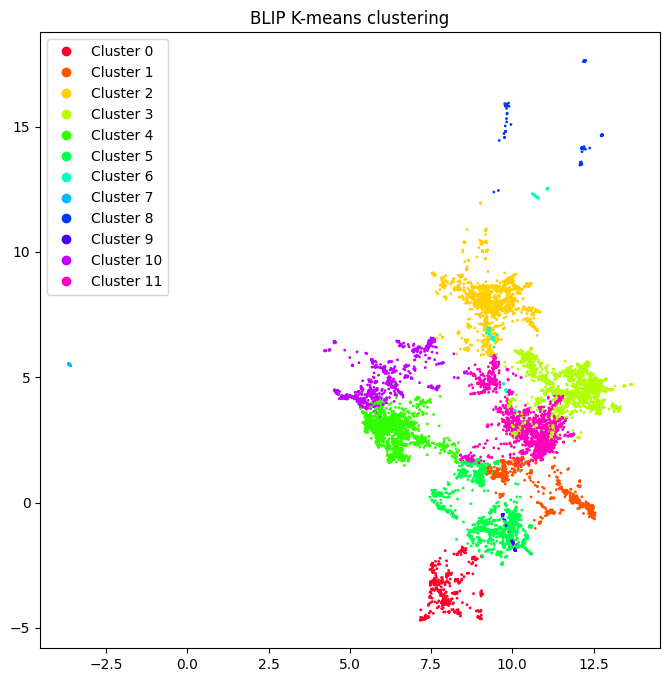

Saved results to ../blip_umap.csv


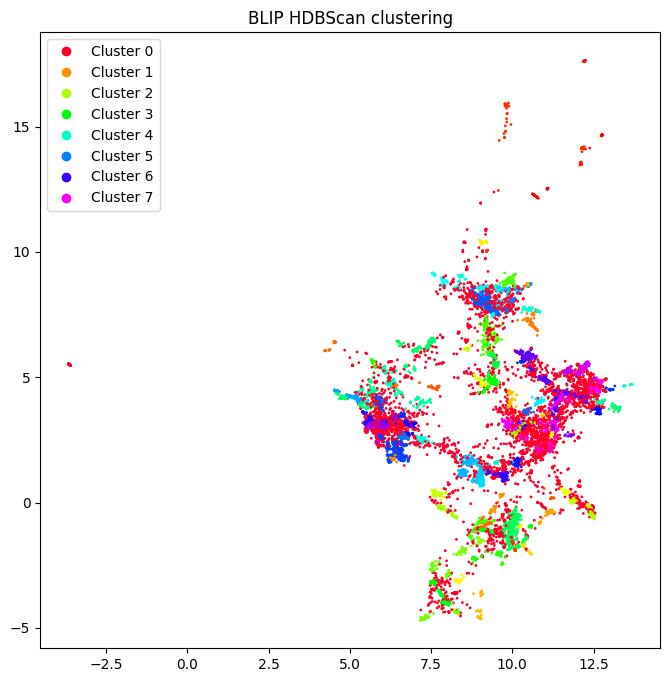

In [68]:
blip_kmeans = Kmeans_clustering(
    blip['image_caption'].to_list(),
    blip_umap_embeddings,
    12,
    '../blip_kmeans.csv',
    True,
    'BLIP K-means clustering'
)

blip_hdbscan = HDBScan_clustering(
    all_captions=blip['image_caption'],
    embeddings=blip_umap_embeddings,
    csv_filepath='../blip_umap.csv',
    show_plot=True,
    plot_title= 'BLIP HDBScan clustering'
)

Saved results to ../kosmos_kmeans.csv


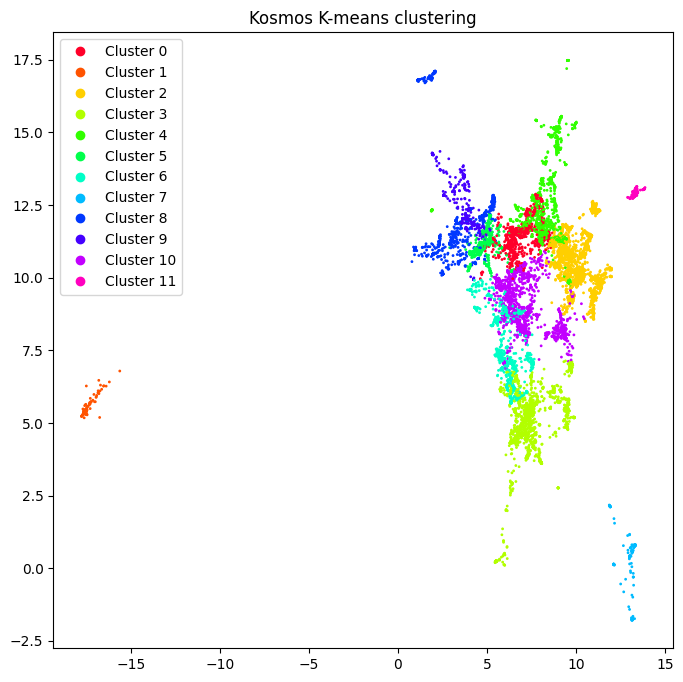

Saved results to ../kosmos_umap.csv


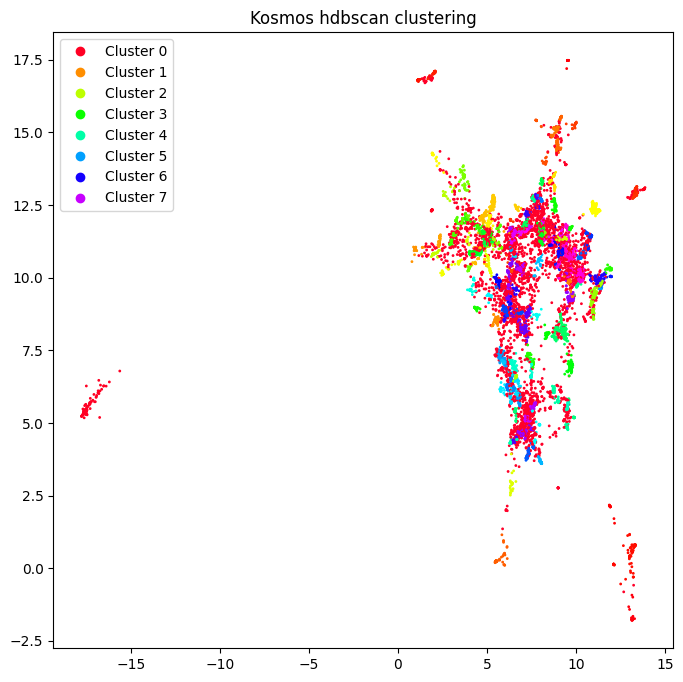

In [67]:
kosmos_kmeans = Kmeans_clustering(
    kosmos['image_caption'].to_list(),
    kosmos_umap_embeddings,
    12,
    '../kosmos_kmeans.csv',
    True,
    'Kosmos K-means clustering'
)

kosmos_hdbscan = HDBScan_clustering(
    all_captions=kosmos['image_caption'],
    embeddings=kosmos_umap_embeddings,
    csv_filepath='../kosmos_umap.csv',
    show_plot=True,
    plot_title='Kosmos HDBScan clustering'
)